#### Notebook to plot expression by genotypes for eQTL result
ie visualize genotype's effect on expression for specific variant(s)

In [1]:
!date

Tue Jul 27 21:05:53 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import torch
import tensorqtl.tensorqtl as tensorqtl
from tensorqtl.tensorqtl import genotypeio
print('PyTorch {}'.format(torch.__version__))
print('Pandas {}'.format(pd.__version__))
import seaborn as sns
import matplotlib.pyplot as plt

PyTorch 1.8.0
Pandas 1.2.4


In [3]:
# parameters
cohort = 'ppmi'
version = 'amppdv1'
visit = 0
visit_name = 'BLM0T1'
tissue = 'wb'
# gene_name = 'PAM'
# gene_id = 'ENSG00000145730.20'
# variant = 'rs11329963'
# gene_name = 'CRLS1'
# gene_id = 'ENSG00000088766.11'
# variant = 'rs77351827'
gene_name = 'LRRK2'
gene_id = 'ENSG00000188906.15'
# variant = 'rs76904798'
variant = 'rs34637584' #G2019S
interaction_term = 'predicted_Lymphocytes'
term_file = f'/home/jupyter/{cohort}/sample_info/{cohort}_rna_sample_info.csv'
# interaction_term = 'GRS'
# term_file = '/home/jupyter/ppmi/sample_info/ppmi.grs.scaled.csv'

In [4]:
# naming
cohort_version = f'{cohort}.{version}'
cohort_build = f'{cohort}.{tissue}{visit}'

if interaction_term == '':
    interaction_term = None
    term_file = None

# directories
home_dir = f'/home/jupyter'
wrk_dir = f'/{home_dir}/{cohort}'
geno_dir = f'{wrk_dir}/genotypes'
expr_dir = f'{wrk_dir}/expression'

# input files
# expr_files = {visit: f'{expr_dir}/{cohort}.{tissue}{visit}.norm.adj.bed.gz' for visit in visits}
expr_bed_file = f'{expr_dir}/{cohort_build}.norm.adj.bed.gz'
bfile_prefix_path = f'{geno_dir}/{cohort_version}.bfile'
gencode_pkl = f'{home_dir}/amppd/expression/gencode.v29.primary_assembly.annotation.pkl'

# output files


#### load plink bfiles

In [5]:
%%time

# pr = genotypeio.PlinkReader(bfile_prefix_path, select_samples=phenotype_df.columns)
pr = genotypeio.PlinkReader(bfile_prefix_path)
genotype_df = pr.load_genotypes()
variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]

Mapping files: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


CPU times: user 1min 55s, sys: 15 s, total: 2min 10s
Wall time: 53 s


In [6]:
# display(genotype_df.head())
# display(variant_df.head())

#### load phenotypes and covariates (if needed)

In [7]:
%%time

phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expr_bed_file)
print(f'phenotype_df {phenotype_df.shape}')
print(f'phenotype_pos_df {phenotype_pos_df.shape}')

phenotype_df (16235, 1511)
phenotype_pos_df (16235, 2)
CPU times: user 8.12 s, sys: 121 ms, total: 8.24 s
Wall time: 8.24 s


In [8]:
# display(phenotype_df.head())
# display(phenotype_pos_df.head())

In [9]:
if not interaction_term is None:
    covs_df = pd.read_csv(term_file, index_col=0)
    print(f'covariates_df {covs_df.shape}')
    # go ahead and subset to specified term of interest
    # have two different covariate and interaction term formats to deal with
    try:
        term_df = covs_df.loc[(covs_df['visit'] == visit_name) & 
                              (covs_df['wgsid'].isin(phenotype_df.columns)), 
                              ['visit', 'wgsid', interaction_term]]
    except:
        term_df = covs_df.loc[(covs_df.index.isin(phenotype_df.columns)), 
                              [interaction_term]].copy()
        term_df['visit'] = visit_name
        term_df['wgsid'] = term_df.index
    print(f'term_df {term_df.shape}')
#     display(term_df.head())
else:
    term_df = None

covariates_df (4610, 56)
term_df (1511, 3)


#### subset dataframes to relevant features and transpose

In [10]:
gene_pheno_df = phenotype_df.loc[phenotype_df.index == gene_id].T
print(gene_pheno_df.shape)
# display(gene_pheno_df.head())

(1511, 1)


In [11]:
variant_geno_df = genotype_df.loc[genotype_df.index == variant].T
print(variant_geno_df.shape)
# display(variant_geno_df.head())

(1276, 1)


#### merge the data frames

In [12]:
merged_df = variant_geno_df.merge(gene_pheno_df, how='inner', 
                                  left_index=True, right_index=True)
print(merged_df.shape)
if not term_df is None:
    merged_df = merged_df.merge(term_df, how='inner', left_index=True, right_on='wgsid')

print(merged_df.shape)
# display(merged_df.head())

(1192, 2)
(1192, 5)


#### generate the plot(s)

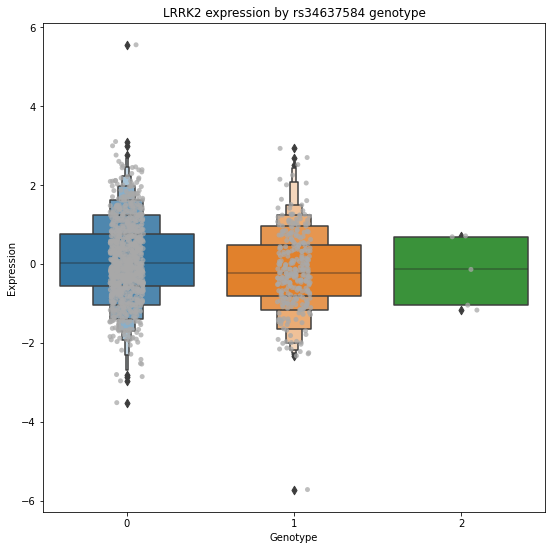

In [13]:
# plot typical expression by genotype plot
plt.figure(figsize=(9,9))
sns.boxenplot(x=variant, y=gene_id, scale='exponential', 
              data=merged_df, k_depth='trustworthy')

grsplt = sns.stripplot(x=variant, y=gene_id, data=merged_df, alpha=0.75, 
                       jitter=True, color='darkgrey')
loc, labels = plt.xticks()
grsplt.set_xticklabels(labels)
plt.title(f'{gene_name} expression by {variant} genotype', fontsize='large') 
plt.xlabel('Genotype')
plt.ylabel('Expression')
plt.show()

<Figure size 648x648 with 0 Axes>

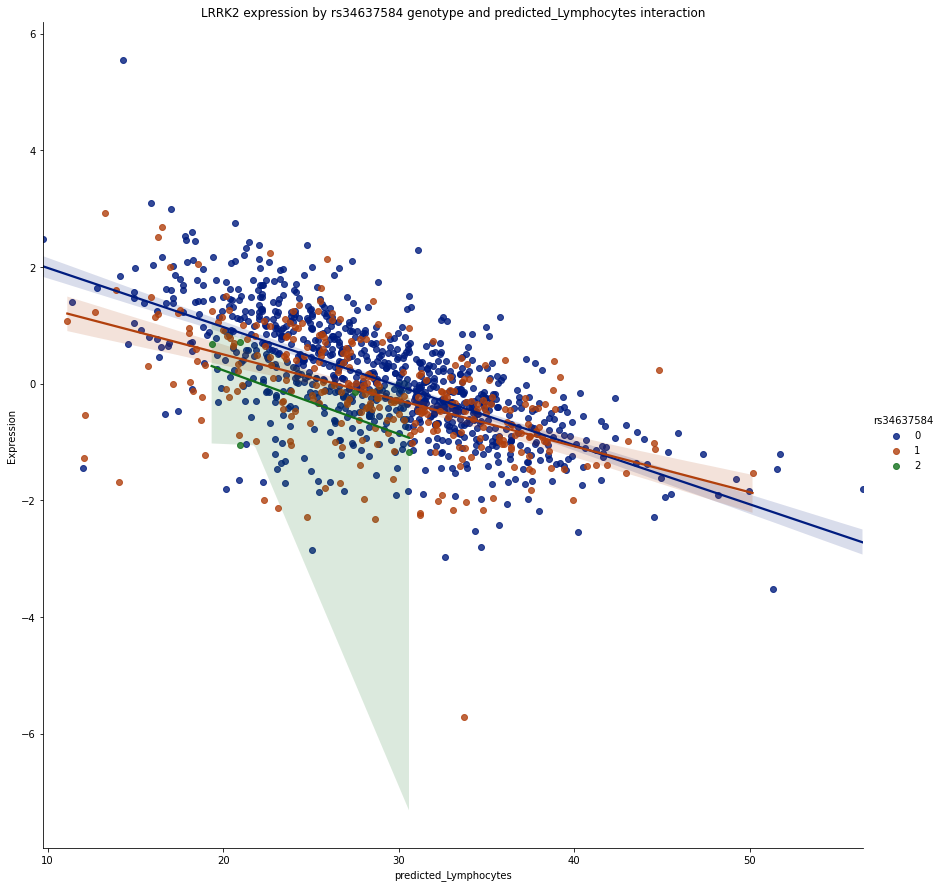

In [14]:
if not interaction_term is None:
    plt.figure(figsize=(9,9))
    sns.lmplot(x=interaction_term, 
               y=gene_id, hue=variant, 
               palette="dark", height=12, data=merged_df)
    plt.title(f'{gene_name} expression by {variant} genotype and {interaction_term} interaction', 
              fontsize='large') 
    plt.xlabel(f'{interaction_term}')
    plt.ylabel('Expression')
    plt.show()